In [1]:
# ---------------------------------------------------
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

import graphviz
# ----------------------------------------------------------------
# 글꼴
import matplotlib.font_manager as fm
path =  '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'
fontprop = fm.FontProperties(fname=path, size=18).get_name()

matplotlib.rc('font', family=fontprop)
matplotlib.rc('axes', unicode_minus = False)

# ---------------------------------------------------------------------------------
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 학습/평가용 데이터 분리
from sklearn.model_selection import train_test_split
# 선형회귀 모형
from sklearn.linear_model import LinearRegression
# 변수선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [2]:
df_raw = pd.read_csv("/home/piai/바탕화면/빅데이터/1 Big Data 분석 기초/체질검사.csv")
df_raw.head()
#  데이터 불러오기

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST  
0    45.0     29.0   21.4  
1    29.0     30.0   18.8  
2    30.8     25.7   18.8  
3    31.7     27.3   16.9  
4    34.7     29.1   18.4

In [3]:
df_raw.describe().round(3)

FAT      AGE   WEIGHT   HEIGHT     NECK    CHEST  ABDOMEN      HIP  \
count  252.000  252.000  252.000  252.000  252.000  252.000  252.000  252.000   
mean    19.151   44.885  178.924   70.149   37.992  100.824   92.556   99.905   
std      8.369   12.602   29.389    3.663    2.431    8.430   10.783    7.164   
min      0.000   22.000  118.500   29.500   31.100   79.300   69.400   85.000   
25%     12.475   35.750  159.000   68.250   36.400   94.350   84.575   95.500   
50%     19.200   43.000  176.500   70.000   38.000   99.650   90.950   99.300   
75%     25.300   54.000  197.000   72.250   39.425  105.375   99.325  103.525   
max     47.500   81.000  363.150   77.750   51.200  136.200  148.100  147.700   

         THIGH     KNEE    ANKLE   BICEPS  FOREARM    WRIST  
count  252.000  252.000  252.000  252.000  252.000  252.000  
mean    59.406   38.590   23.102   32.273   28.664   18.230  
std      5.250    2.412    1.695    3.021    2.021    0.934  
min     47.200   33.000   19.100   24.800   21.000   15.800  
25%     56.000   36.975   22.000   30.200   27.300   17.600  
50%     59.000   38.500   22.800   32.050   28.700   18.300  
75%     62.350   39.925   24.000   34.325   30.000   18.800  
max     87.300   49.100   33.900   45.000   34.900   21.400

In [4]:
df_raw.dtypes
#  BMI를 추가하기 전 각 열의 자료형 확인 / 만약 object로 저장되어있었다면 숫자형으로 변환해야 한다.

FAT        float64
AGE          int64
WEIGHT     float64
HEIGHT     float64
NECK       float64
CHEST      float64
ABDOMEN    float64
HIP        float64
THIGH      float64
KNEE       float64
ANKLE      float64
BICEPS     float64
FOREARM    float64
WRIST      float64
dtype: object

In [5]:
lb_to_kg = 0.45
#  lb를 kg로 변환
inch_to_m = 2.54/100
#  inch를 m값으로 변환 ~ BMI 식의 키 단위가 m이기 때문에 미리 변환
df_raw['BMI'] = ((df_raw['WEIGHT']*lb_to_kg) / ((df_raw['HEIGHT']*inch_to_m) * (df_raw['HEIGHT']*inch_to_m)))
# round(반올림) 적용안함 ~ 작은 값이지만 다른 값들에 영향을 줄 수 있어서, 반올림하지 않고 도출된 값 그대로 사용을 결정했음.  
df_raw.head()

# BMI 몸무게_kg / (키 제곱)_m

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST        BMI  
0    45.0     29.0   21.4  48.523870  
1    29.0     30.0   18.8  23.082595  
2    30.8     25.7   18.8  26.422478  
3    31.7     27.3   16.9  23.838617  
4    34.7     29.1   18.4  37.293165

In [6]:
df_raw.columns

Index(['FAT', 'AGE', 'WEIGHT', 'HEIGHT', 'NECK', 'CHEST', 'ABDOMEN', 'HIP',
       'THIGH', 'KNEE', 'ANKLE', 'BICEPS', 'FOREARM', 'WRIST', 'BMI'],
      dtype='object')

In [7]:
df_raw.isnull().sum()
# 결측치 확인

#  확인 결과 결측치 없음

FAT        0
AGE        0
WEIGHT     0
HEIGHT     0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
BMI        0
dtype: int64

In [8]:
df_raw.describe()
#  기술통계량 확인

#  75% 값에서 max 차이가 50%이상 차이나는 수상한 최대값 확인 ~ WEIGHT, BMI

FAT         AGE      WEIGHT      HEIGHT        NECK       CHEST  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    19.150794   44.884921  178.924405   70.148810   37.992063  100.824206   
std      8.368740   12.602040   29.389160    3.662856    2.430913    8.430476   
min      0.000000   22.000000  118.500000   29.500000   31.100000   79.300000   
25%     12.475000   35.750000  159.000000   68.250000   36.400000   94.350000   
50%     19.200000   43.000000  176.500000   70.000000   38.000000   99.650000   
75%     25.300000   54.000000  197.000000   72.250000   39.425000  105.375000   
max     47.500000   81.000000  363.150000   77.750000   51.200000  136.200000   

          ABDOMEN         HIP       THIGH        KNEE       ANKLE      BICEPS  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    92.555952   99.904762   59.405952   38.590476   23.102381   32.273413   
std     10.783077    7.164058    5.249952    2.411805    1.694893    3.021274   
min     69.400000   85.000000   47.200000   33.000000   19.100000   24.800000   
25%     84.575000   95.500000   56.000000   36.975000   22.000000   30.200000   
50%     90.950000   99.300000   59.000000   38.500000   22.800000   32.050000   
75%     99.325000  103.525000   62.350000   39.925000   24.000000   34.325000   
max    148.100000  147.700000   87.300000   49.100000   33.900000   45.000000   

          FOREARM       WRIST         BMI  
count  252.000000  252.000000  252.000000  
mean    28.663889   18.229762   25.736762  
std      2.020691    0.933585    9.482758  
min     21.000000   15.800000   17.874982  
25%     27.300000   17.600000   22.853241  
50%     28.700000   18.300000   24.895566  
75%     30.000000   18.800000   27.118085  
max     34.900000   21.400000  164.306562

In [9]:
df_raw.boxplot(['BMI'])
plt.show()
#  boxplot 을 이용해서 튀는 값 확인

In [10]:
df_raw[df_raw["BMI"]>160]
#  HEIGHT(키) 29.5inch에 비해 WEIGHT(몸무게) 205lb인 이상치 발견

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  \
78  32.9   44   205.0    29.5  36.6  106.0    104.3  115.5   70.6  42.5   

    ANKLE  BICEPS  FOREARM  WRIST         BMI  
78   23.7    33.6     28.7   17.4  164.306562

In [11]:
df_raw.drop(df_raw[df_raw['BMI'] > 160].index, inplace=True)
#  BMI 160

In [12]:
df_raw.iloc[77:79]
#  정상적으로 78행이 삭제되었는지 확인

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN   HIP  THIGH  KNEE  ANKLE  \
77  14.1   48  176.00    73.0  36.7   96.7     86.5  98.3   60.4  39.9   24.4   
79   3.7   27  159.25    71.5  35.7   89.6     79.7  96.5   55.0  36.7   22.5   

    BICEPS  FOREARM  WRIST        BMI  
77    28.8     29.6   18.7  23.036263  
79    29.9     28.2   17.7  21.727634

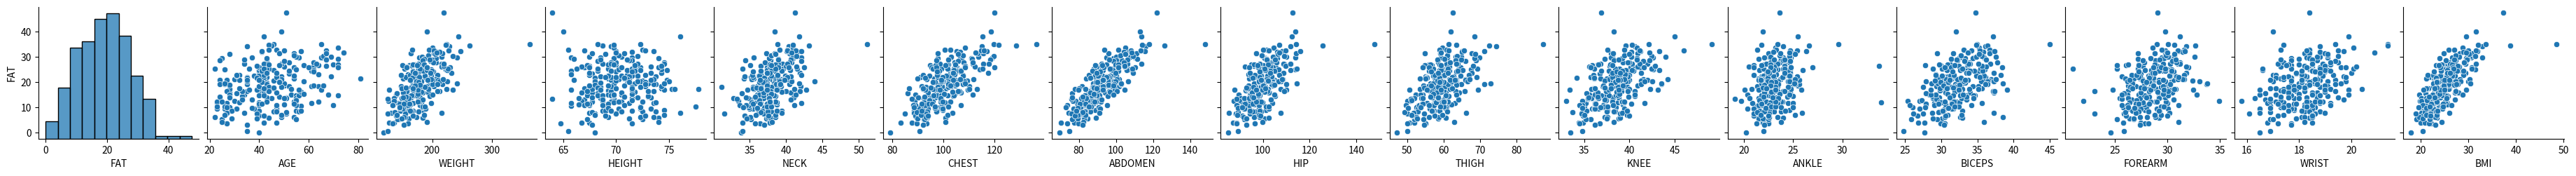

In [13]:
sns.pairplot(df_raw, y_vars = "FAT")
plt.show()
#  목표변수 FAT와 관계있는 설명변수 AGE, WEIGHT NECK CHEST ABDOMEN 등을 확인

#  대부분 목표변수 FAT와 선형성(+)을 띄는 것으로 보임

In [14]:
sns.pairplot(df_raw, y_vars = "FAT", kind="reg")
plt.show()
#  목표변수와 설명변수 간 ~ 선형관계 확인

In [15]:
sns.pairplot(df_raw)
plt.show()

In [16]:
df_raw.corr().round(3)
#  상관관계 분석

FAT    AGE  WEIGHT  HEIGHT   NECK  CHEST  ABDOMEN    HIP  THIGH  \
FAT      1.000  0.294   0.611  -0.023  0.497  0.703    0.813  0.620  0.554   
AGE      0.294  1.000  -0.013  -0.245  0.113  0.177    0.231 -0.050 -0.201   
WEIGHT   0.611 -0.013   1.000   0.489  0.835  0.894    0.888  0.944  0.870   
HEIGHT  -0.023 -0.245   0.489   1.000  0.321  0.228    0.192  0.378  0.344   
NECK     0.497  0.113   0.835   0.321  1.000  0.787    0.759  0.748  0.708   
CHEST    0.703  0.177   0.894   0.228  0.787  1.000    0.916  0.833  0.732   
ABDOMEN  0.813  0.231   0.888   0.192  0.759  0.916    1.000  0.875  0.766   
HIP      0.620 -0.050   0.944   0.378  0.748  0.833    0.875  1.000  0.894   
THIGH    0.554 -0.201   0.870   0.344  0.708  0.732    0.766  0.894  1.000   
KNEE     0.503  0.018   0.853   0.505  0.680  0.720    0.736  0.821  0.797   
ANKLE    0.265 -0.105   0.614   0.394  0.479  0.483    0.453  0.561  0.542   
BICEPS   0.493 -0.041   0.800   0.319  0.733  0.728    0.685  0.743  0.765   
FOREARM  0.363 -0.085   0.631   0.322  0.624  0.581    0.504  0.550  0.572   
WRIST    0.355  0.214   0.735   0.397  0.744  0.664    0.626  0.645  0.572   
BMI      0.725  0.115   0.888   0.039  0.785  0.910    0.922  0.885  0.814   

          KNEE  ANKLE  BICEPS  FOREARM  WRIST    BMI  
FAT      0.503  0.265   0.493    0.363  0.355  0.725  
AGE      0.018 -0.105  -0.041   -0.085  0.214  0.115  
WEIGHT   0.853  0.614   0.800    0.631  0.735  0.888  
HEIGHT   0.505  0.394   0.319    0.322  0.397  0.039  
NECK     0.680  0.479   0.733    0.624  0.744  0.785  
CHEST    0.720  0.483   0.728    0.581  0.664  0.910  
ABDOMEN  0.736  0.453   0.685    0.504  0.626  0.922  
HIP      0.821  0.561   0.743    0.550  0.645  0.885  
THIGH    0.797  0.542   0.765    0.572  0.572  0.814  
KNEE     1.000  0.613   0.680    0.559  0.675  0.709  
ANKLE    0.613  1.000   0.485    0.419  0.568  0.497  
BICEPS   0.680  0.485   1.000    0.678  0.635  0.747  
FOREARM  0.559  0.419   0.678    1.000  0.587  0.561  
WRIST    0.675  0.568   0.635    0.587  1.000  0.635  
BMI      0.709  0.497   0.747    0.561  0.635  1.000

In [17]:
df_train, df_test = train_test_split(df_raw, test_size = 0.4, random_state = 1234)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))
#  Data ( test 0.4 / train 0.6 ) 비율로 정함

train data size : (150, 15)
test data size : (101, 15)


In [18]:
reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT +\
HEIGHT + NECK + CHEST +\
ABDOMEN + HIP + THIGH +\
KNEE + ANKLE + BICEPS +\
FOREARM + WRIST + BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     28.28
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.29e-33
Time:                        22:49:09   Log-Likelihood:                -429.93
No. Observations:                 150   AIC:                             889.9
Df Residuals:                     135   BIC:                             935.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -190.6032     73.021     -2.610      0.0

In [19]:
# 해석

#     Prob(Omnibus) : 0.229 > 0.05 이므로 정규성 만족
#     Durbin-Watson : 2.211이므로 '2' 에 가까워 독립성 만족
#     No. Observations: 150 분석 자료수
#     Df Residuals: 135 잔차자유도
#     Df Model: 14 모델자유도
#     prob p값이 2.29e-40으로 유의수준 0.05보다 작으므로 회귀모델로서 유의함
#     설명력 0.719 -> 주어진 설명변수들로 FAT의 변동의 71.9%를 설명할 수 있음
#     회귀계수 검정(t) -> 절편의 유의성(Intercept)는 검토하지 않음



In [20]:
#  VIF / 선형회귀 모형 검정을 통해 하나씩 확인하여 변수를 제거
df_train_x = df_train.drop('FAT', axis=1)
df_train_x_const = add_constant(df_train_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF", ascending = True).round(2)

variable       VIF
10    ANKLE      2.20
12  FOREARM      2.59
1       AGE      2.65
13    WRIST      3.42
4      NECK      4.58
11   BICEPS      4.71
9      KNEE      4.72
8     THIGH      7.86
5     CHEST     11.17
6   ABDOMEN     15.41
7       HIP     15.81
3    HEIGHT     53.67
14      BMI    246.51
2    WEIGHT    261.54
0     const  39824.86

In [21]:
                                                  
#  WEIGHT 261.54 > VIF 10 이므로 가장 큰 변수인 WEIGHT 제거

df_train_x = df_train.drop(['FAT','WEIGHT'], axis=1)
df_train_x_const = add_constant(df_train_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF", ascending = True).round(2)

variable      VIF
9     ANKLE     2.20
11  FOREARM     2.43
1       AGE     2.63
12    WRIST     3.42
3      NECK     4.41
10   BICEPS     4.49
8      KNEE     4.51
2    HEIGHT     5.51
7     THIGH     7.76
4     CHEST    10.97
5   ABDOMEN    15.33
6       HIP    15.81
13      BMI    38.99
0     const  1102.77

In [22]:

#  BMI 38.99 > VIF 10 이므로 가장 큰 변수인 BMI 제거

df_train_x = df_train.drop(['FAT', 'WEIGHT', 'BMI'], axis=1)
df_train_x_const = add_constant(df_train_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF", ascending = True).round(2)

variable      VIF
2    HEIGHT     1.90
9     ANKLE     1.98
11  FOREARM     2.40
1       AGE     2.52
12    WRIST     3.39
3      NECK     4.01
10   BICEPS     4.34
8      KNEE     4.51
7     THIGH     7.75
4     CHEST     8.81
6       HIP    11.19
5   ABDOMEN    12.93
0     const  1064.69

In [23]:

#  ABDOMEN 12.93 > VIF 10 이므로 가장 큰 변수인 ABDOMEN 제거

df_train_x = df_train.drop(['FAT', 'WEIGHT','BMI', 'ABDOMEN'], axis=1)
df_train_x_const = add_constant(df_train_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF", ascending = True).round(2)

variable     VIF
2    HEIGHT    1.81
8     ANKLE    1.97
1       AGE    2.05
10  FOREARM    2.39
11    WRIST    3.38
3      NECK    4.00
9    BICEPS    4.31
7      KNEE    4.46
4     CHEST    5.45
6     THIGH    7.56
5       HIP    9.20
0     const  996.28

In [24]:
# 처음의 회귀분석 결과의 가장 큰값 P 0.599인 THIGH 제거

reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT +\
HEIGHT + NECK + CHEST +\
ABDOMEN + HIP +        \
KNEE + ANKLE + BICEPS +\
FOREARM + WRIST + BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 


                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     30.59
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           4.62e-34
Time:                        22:49:09   Log-Likelihood:                -430.08
No. Observations:                 150   AIC:                             888.2
Df Residuals:                     136   BIC:                             930.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -185.6464     72.219     -2.571      0.0

In [25]:
# THIGH 제거 후 회귀분석 결과의 가장 큰값 P 0.492인 ANKLE 제거

reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT +\
HEIGHT + NECK + CHEST +\
ABDOMEN + HIP +        \
KNEE          + BICEPS +\
FOREARM + WRIST + BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     33.23
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           9.84e-35
Time:                        22:49:09   Log-Likelihood:                -430.35
No. Observations:                 150   AIC:                             886.7
Df Residuals:                     137   BIC:                             925.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -185.5406     72.081     -2.574      0.0

In [26]:
# THIGH, ANKLE 제거 후 회귀분석 결과의 가장 큰값 P 0.453인 FOREARM 제거

reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT +\
HEIGHT + NECK + CHEST +\
ABDOMEN + HIP +        \
KNEE          + BICEPS +\
          WRIST + BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     36.31
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.09e-35
Time:                        22:49:09   Log-Likelihood:                -430.66
No. Observations:                 150   AIC:                             885.3
Df Residuals:                     138   BIC:                             921.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -197.2812     70.259     -2.808      0.0

In [27]:
# THIGH, ANKLE, FOREARM 제거 후 회귀분석 결과의 가장 큰값 P 0.234인 AGE 제거

reg_model = smf.ols(formula = "FAT ~       WEIGHT +\
HEIGHT + NECK + CHEST +\
ABDOMEN + HIP +        \
KNEE          + BICEPS +\
          WRIST + BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     39.68
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           6.46e-36
Time:                        22:49:09   Log-Likelihood:                -431.43
No. Observations:                 150   AIC:                             884.9
Df Residuals:                     139   BIC:                             918.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -184.6693     69.567     -2.655      0.0

In [28]:
# THIGH, ANKLE, FOREARM, AGE 제거 후 회귀분석 결과의 가장 큰값 P 0.187인 KNEE 제거

reg_model = smf.ols(formula = "FAT ~       WEIGHT +\
HEIGHT + NECK + CHEST +\
ABDOMEN + HIP +        \
              + BICEPS +\
          WRIST + BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     43.66
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.22e-36
Time:                        22:49:09   Log-Likelihood:                -432.37
No. Observations:                 150   AIC:                             884.7
Df Residuals:                     140   BIC:                             914.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -163.9117     67.962     -2.412      0.0

In [29]:
# THIGH, ANKLE, FOREARM, AGE, KNEE 제거 후 회귀분석 결과의 가장 큰값 P 0.109인 CHEST 제거

reg_model = smf.ols(formula = "FAT ~       WEIGHT +\
HEIGHT + NECK +        \
ABDOMEN + HIP +        \
              + BICEPS +\
          WRIST + BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     48.24
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.10e-36
Time:                        22:49:09   Log-Likelihood:                -433.75
No. Observations:                 150   AIC:                             885.5
Df Residuals:                     141   BIC:                             912.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -145.7477     67.401     -2.162      0.0

In [30]:
# THIGH, ANKLE, FOREARM, AGE, KNEE, CHEST 제거 후 회귀분석 결과의 가장 큰값 P 0.107인 WRIST 제거

reg_model = smf.ols(formula = "FAT ~       WEIGHT +\
HEIGHT + NECK +        \
ABDOMEN + HIP +        \
              + BICEPS +\
                 BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     54.13
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           5.18e-37
Time:                        22:49:09   Log-Likelihood:                -435.14
No. Observations:                 150   AIC:                             886.3
Df Residuals:                     142   BIC:                             910.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -152.6658     67.653     -2.257      0.0

In [31]:
# THIGH, ANKLE, FOREARM, AGE, KNEE, CHEST, WRIST 제거 후 회귀분석 결과의 가장 큰값 P 0.061인 BICEPS 제거

reg_model = smf.ols(formula = "FAT ~       WEIGHT +\
HEIGHT + NECK +        \
ABDOMEN + HIP +        \
                       \
                 BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     61.45
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           3.60e-37
Time:                        22:49:09   Log-Likelihood:                -437.00
No. Observations:                 150   AIC:                             888.0
Df Residuals:                     143   BIC:                             909.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -130.9102     67.264     -1.946      0.0

In [32]:
# THIGH, ANKLE, FOREARM, AGE, KNEE, CHEST, WRIST, BICEPS 제거 후 회귀분석 결과의 가장 큰값 P 0.052인 HEIGHT 제거

reg_model = smf.ols(formula = "FAT ~       WEIGHT +\
         NECK +        \
ABDOMEN + HIP +        \
                       \
                 BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     71.57
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.61e-37
Time:                        22:49:09   Log-Likelihood:                -438.98
No. Observations:                 150   AIC:                             890.0
Df Residuals:                     144   BIC:                             908.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1227     13.900     -0.153      0.8

In [33]:
# THIGH, ANKLE, FOREARM, AGE, KNEE, CHEST, WRIST, BICEPS, HEIGHT 제거 후 회귀분석 결과의 가장 큰값 P 0.304인 WEIGHT 제거

reg_model = smf.ols(formula = "FAT ~              \
         NECK +        \
ABDOMEN + HIP +         \
                       \
                   BMI", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     89.16
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           4.37e-38
Time:                        22:49:09   Log-Likelihood:                -439.53
No. Observations:                 150   AIC:                             889.1
Df Residuals:                     145   BIC:                             904.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2805      8.435      1.100      0.2

In [34]:
# THIGH, ANKLE, FOREARM, AGE, KNEE, CHEST, WRIST, BICEPS, HEIGHT, WEIGHT 제거 후 회귀분석 결과의 가장 큰값 P 0.087인 BMI 제거

reg_model = smf.ols(formula = "FAT ~              \
         NECK +        \
ABDOMEN + HIP          \
                       \
                      ", data = df_train)
#  선형회귀 분석/모델 생성

reg_result = reg_model.fit()
print(reg_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     116.3
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.60e-38
Time:                        22:49:09   Log-Likelihood:                -441.05
No. Observations:                 150   AIC:                             890.1
Df Residuals:                     146   BIC:                             902.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8221      6.900      0.119      0.9

In [35]:
#  남은 설명변수 NECK, ABDOMEN, HIP는 모두 P값 0.05보다 작으므로 모형에 유의함
#  3개의 설명변수를 최종 회귀모형으로 설정

plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y = 0, linestyle = '--')
plt.show()
#  잔차의 등분산성을 확인

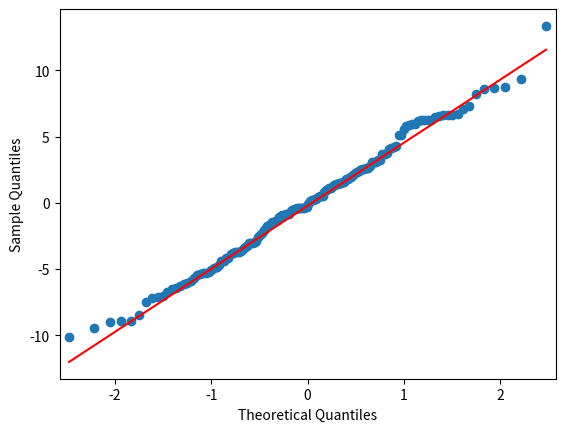

In [36]:
qqplot(reg_result.resid, line = "q")
plt.show()
#  잔차의 정규성을 확인

In [37]:
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-", label="CL")
plt.axhline(y = 3*np.std(reg_result.resid), linestyle = "--", color="red",label = 'UCL')
plt.axhline(y = -3*np.std(reg_result.resid), linestyle = "dashed", color="red",label = 'LCL')
plt.legend();
plt.show()

#  잔차의 독립성을 확인
#  상/하한선을 벗어나지 않고, 기준값을 기준으로 산포되어 있다. 

In [38]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train['FAT'], train_pred))
print("test data의 결정계수:", r2_score(df_test['FAT'], test_pred))
#  평가용 데이터에 대한 성능을 확인

train data의 결정계수: 0.7050493672836544
test data의 결정계수: 0.7237849371397547


In [39]:
df_reg_coef = pd.DataFrame({"Coef":reg_result.params.values[1:]},
                          index = ['NECK', 'ABDOMEN', 'HIP'])
df_reg_coef.plot.barh(y= "Coef")
plt.show()

In [40]:
# 
#  Y = 0.8221 -0.9110*NECK + 0.9774*ABDOMEN -0.3740*HIP
#  Adj. R-squared(결정계수) : 0.699 이므로 설명력 : 69.9%
#  변수 중요도는 abs(ABDOMEN) > abs(NECK)  > abs(HIP) 으로 절대값 1에 가까울 수록 중요한 변수임을 확인할 수 있음
#  ABDOMEN (+) / NECK, HIP (-) 의 상관관계를 가짐.
#    ~ ABDOMEN 측정값이 높을수록 FAT(비만)도가 높게 나타남.
#    ~ 반면 NECK, HIP 측정값이 높을수록 FAT(비만)도가 낮게 나타남.